In [1]:
import os
import pandas as pd
import numpy as np
import yfinance as yf
import math
import pandas_market_calendars as mcal
from matplotlib import pyplot as plt
from matplotlib import dates
from datetime import datetime, timedelta
from tqdm import tqdm
from pytz import timezone

In [2]:
# Define market timezone
MARKET_TZ = timezone('US/Eastern')

def is_market_open(date):
    """Check if the given date is a trading day in the US market."""
    nyse = mcal.get_calendar('NYSE')
    schedule = nyse.schedule(start_date=date, end_date=date)
    return not schedule.empty

def calculate_vwap(data):
    """
    Calculate intraday VWAP for each day.
    VWAP = cumulative (Typical Price * Volume) / cumulative Volume for the day
    """
    data = data.copy()
    data['Date'] = data.index.date
    data[['High', 'Low', 'Close', 'Volume']] = data[['High', 'Low', 'Close', 'Volume']].apply(pd.to_numeric)
    typical_price = (data['High'] + data['Low'] + data['Close']) / 3
    data['TPV'] = typical_price * data['Volume']
    data['Cumul_TPV'] = data.groupby('Date')['TPV'].cumsum()
    data['Cumul_Vol'] = data.groupby('Date')['Volume'].cumsum()
    data['VWAP'] = data['Cumul_TPV'] / data['Cumul_Vol']
    return data

def calculate_atr(data, period=14):
    high_low = data['High'] - data['Low']
    high_close = abs(data['High'] - data['Close'].shift())
    low_close = abs(data['Low'] - data['Close'].shift())
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = tr.rolling(period).mean().bfill()
    return atr

def apply_strategy(data):
    """Apply the HedgeScalp strategy with improved implementation."""
    if len(data) < 20:
        return pd.DataFrame()
        
    try:
        data = calculate_vwap(data)
        data['Vol_MA'] = data['Volume'].rolling(window=30, min_periods=30).mean().ffill()
        data['EMA_7'] = data['Close'].ewm(span=14, adjust=False).mean()
        data['ATR'] = calculate_atr(data)
        
        # Handle potential NaN values
        data = data.ffill().bfill()
        
        # Dynamic threshold with smoothing
        threshold = 1.5 * (data['ATR'] / data['Close']).rolling(14).mean()
        
        # Long Signal with relaxed conditions
        data['LongSignal'] = (
            (data['Close'] < data['VWAP'] * (1 - threshold)) & 
            (data['Volume'] < data['Vol_MA'] * 0.9) &
            (data['Close'] > data['EMA_7']) &
            (data['Volume'] > 100)
        )

        # Short Signal with relaxed conditions
        data['ShortSignal'] = (
            (data['Close'] > data['VWAP'] * (1 + threshold)) & 
            (data['Volume'] < data['Vol_MA'] * 0.9) &
            (data['Close'] < data['EMA_7']) &
            (data['Volume'] > 100)
        )
        
        # Create unified signal column
        data['Signal'] = 0
        data.loc[data['LongSignal'], 'Signal'] = 1
        data.loc[data['ShortSignal'], 'Signal'] = -1
        
        return data.dropna()
        
    except Exception as e:
        print(f"Strategy error: {e}")
        return pd.DataFrame()

def calculate_regulatory_fees(sell_price, shares):
    """Calculate SEC and FINRA fees for a sell order."""
    # SEC fee: $27.80 per $1,000,000 of principal
    principal = sell_price * shares
    sec_fee = (principal / 1e6) * 27.80
    sec_fee = math.ceil(sec_fee * 100) / 100  # Round up to nearest penny

    # FINRA TAF: $0.000166 per share
    taf_fee = shares * 0.000166
    taf_fee = math.ceil(taf_fee * 100) / 100
    taf_fee = min(taf_fee, 8.30)  # Maximum $8.30

    return sec_fee + taf_fee

def calculate_profit_factor(returns):
    """Calculate profit factor: sum of profits / sum of losses."""
    if len(returns) == 0:
        return 0
    
    profits = returns[returns > 0].sum()
    losses = abs(returns[returns < 0].sum())
    
    if losses == 0:
        return float('inf') if profits > 0 else 0
    
    return profits / losses

In [3]:
def get_historical_data(ticker, start_date, end_date):
    """
    Retrieve historical data from local storage or download new data and append.
    Returns timezone-aware DataFrame in MARKET_TZ.
    """
    os.makedirs('historical_data', exist_ok=True)
    file_path = f'historical_data/{ticker}.csv'
    
    # Convert input dates to timezone-aware datetime objects
    start_date = pd.to_datetime(start_date).tz_localize(MARKET_TZ)
    end_date = pd.to_datetime(end_date).tz_localize(MARKET_TZ)
    
    try:
        # Load existing data if available
        if os.path.exists(file_path):
            existing_data = pd.read_csv(file_path, index_col=0, parse_dates=True)
            existing_data.index = existing_data.index.tz_localize(MARKET_TZ)
            last_date = existing_data.index.max()
        else:
            existing_data = pd.DataFrame()
            last_date = None
        
        # Determine date range needed
        download_start = last_date + timedelta(minutes=1) if last_date else start_date
        download_end = end_date
        
        # Only download if needed
        if not last_date or download_start < download_end:
            # Download new data
            new_data = yf.download(ticker, 
                                 start=download_start.tz_localize(None), 
                                 end=download_end.tz_localize(None),
                                 interval='1m')
            
            if not new_data.empty:
                # If data has multiple column levels, reduce to a single level.
                if isinstance(new_data.columns, pd.MultiIndex):
                    new_data.columns = new_data.columns.get_level_values(0)
                    
                # Convert index to market timezone
                new_data.index = new_data.index.tz_convert(MARKET_TZ)
                
                # Combine with existing data
                combined_data = pd.concat([existing_data, new_data])
                # Remove duplicates keeping last entry
                combined_data = combined_data[~combined_data.index.duplicated(keep='last')]
                combined_data.sort_index(inplace=True)
                
                # Save with naive timestamp
                combined_data_naive = combined_data.copy()
                combined_data_naive.index = combined_data_naive.index.tz_localize(None)
                combined_data_naive.to_csv(file_path)
            else:
                combined_data = existing_data
        else:
            combined_data = existing_data
        
        # Filter for requested date range
        filtered_data = combined_data.loc[start_date:end_date]
        return filtered_data
    
    except Exception as e:
        print(f"Error loading data for {ticker}: {e}")
        return pd.DataFrame()

In [4]:
def run_backtest(tickers, start_date, end_date, use_trailing_stop=True, exit_bars=60):
    """
    Run a backtest of the HedgeScalp strategy on multiple stocks
    
    Parameters:
    - tickers: List of stock symbols
    - start_date: Starting date for backtest
    - end_date: Ending date for backtest
    - use_trailing_stop: Whether to use trailing stops
    - exit_bars: Number of bars (minutes) before time-based exit
    
    Returns:
    - DataFrame of all trades and performance metrics
    """
    all_trades = []
    trade_logs = {}
    
    pbar = tqdm(tickers, desc="Processing Stocks")
    for ticker in pbar:
        pbar.set_description(f"Processing {ticker}")
        try:
            data = get_historical_data(ticker, start_date, end_date)
            if data.empty:
                continue
            
            # Apply HedgeScalp strategy to generate signals.
            data = apply_strategy(data)
            
            # Skip if no signals were generated.
            if 'Signal' not in data.columns or data['Signal'].abs().sum() == 0:
                continue
            
            # Initialize tracking for this ticker
            active_trades = {}
            ticker_trades = []
            
            # Process day by day
            for day, day_data in data.groupby(data.index.date):
                # Track VWAP components for this day
                cumul_tpv = 0
                cumul_vol = 0
                
                # Process each bar (minute) during the day
                for t, row in day_data.iterrows():
                    # Update VWAP for this bar
                    tp = (row['High'] + row['Low'] + row['Close']) / 3
                    cumul_tpv += tp * row['Volume']
                    cumul_vol += row['Volume']
                    
                    vwap = cumul_tpv / cumul_vol if cumul_vol > 0 else row['Close']
                    
                    # Check trailing stops for active trades
                    trades_to_close = []
                    for entry_time, trade in active_trades.items():
                        if use_trailing_stop:
                            # For long positions, trailing stop is previous candle's close
                            if trade['Direction'] == 'Long':
                                prev_idx = day_data.index.get_loc(t) - 1
                                if prev_idx > 0:
                                    new_stop = day_data['Close'].iloc[prev_idx]
                                    if trade['Stop'] is None or new_stop > trade['Stop']:
                                        active_trades[entry_time]['Stop'] = new_stop
                                        
                                    # Check if current price hits trailing stop
                                    if row['Low'] <= trade['Stop']:
                                        trade['Exit Price'] = trade['Stop']
                                        trade['Exit Time'] = t
                                        trade['Exit Reason'] = 'Trailing Stop'
                                        
                                        # Calculate return
                                        ret = (trade['Exit Price'] - trade['Entry Price']) / trade['Entry Price']
                                        trade['Return'] = ret
                                        trade['Return %'] = ret * 100
                                        
                                        ticker_trades.append(trade)
                                        trades_to_close.append(entry_time)
                            
                            # For short positions, trailing stop is previous candle's open
                            elif trade['Direction'] == 'Short':
                                prev_idx = day_data.index.get_loc(t) - 1
                                if prev_idx > 0:
                                    new_stop = day_data['Open'].iloc[prev_idx]
                                    if trade['Stop'] is None or new_stop < trade['Stop']:
                                        active_trades[entry_time]['Stop'] = new_stop
                                        
                                    # Check if current price hits trailing stop
                                    if row['High'] >= trade['Stop']:
                                        trade['Exit Price'] = trade['Stop']
                                        trade['Exit Time'] = t
                                        trade['Exit Reason'] = 'Trailing Stop'
                                        
                                        # Calculate return
                                        ret = (trade['Entry Price'] - trade['Exit Price']) / trade['Entry Price']
                                        trade['Return'] = ret
                                        trade['Return %'] = ret * 100
                                        
                                        ticker_trades.append(trade)
                                        trades_to_close.append(entry_time)
                        
                        # Time-based exit (after exit_bars minutes)
                        time_passed = (t - entry_time).total_seconds() / 60
                        if time_passed >= exit_bars:
                            trade['Exit Price'] = row['Close']
                            trade['Exit Time'] = t
                            trade['Exit Reason'] = 'Time-based'
                            
                            if trade['Direction'] == 'Long':
                                ret = (trade['Exit Price'] - trade['Entry Price']) / trade['Entry Price']
                            else:
                                ret = (trade['Entry Price'] - trade['Exit Price']) / trade['Entry Price']
                                
                            trade['Return'] = ret
                            trade['Return %'] = ret * 100
                            
                            ticker_trades.append(trade)
                            trades_to_close.append(entry_time)
                    
                    # Remove closed trades
                    for entry_time in trades_to_close:
                        del active_trades[entry_time]
                    
                    # Process new entry signals when not in a position
                    if t not in active_trades and row['Signal'] != 0:
                        direction = 'Long' if row['Signal'] == 1 else 'Short'

                        position_size = 1000  # $10,00 per trade
                        shares = position_size // row['Close']
                        
                        # Set initial trailing stop
                        initial_stop = None
                        prev_idx = day_data.index.get_loc(t) - 1 if t in day_data.index else -1
                        if prev_idx > 0:
                            if direction == 'Long':
                                initial_stop = day_data['Close'].iloc[prev_idx]
                            else:
                                initial_stop = day_data['Open'].iloc[prev_idx]

                        if direction == 'Short':
                            entry_fee = calculate_regulatory_fees(row['Close'], shares)
                            # Store fee to deduct from returns later
                            fee_impact = entry_fee / (row['Close'] * shares)
                        else:
                            fee_impact = 0
                        
                        active_trades[t] = {
                            'Symbol': ticker,
                            'DateTime': t,
                            'Direction': direction,
                            'Entry Price': row['Close'],
                            'Shares': shares,
                            'Fee Impact': fee_impact,
                            'Stop': initial_stop,
                            'VWAP': vwap,
                            'Volume': row['Volume'],
                            'Vol_MA': row['Vol_MA'],
                        }
                        
                        # print(f"{direction} {ticker} at {row['Close']:.2f} on {t} (RSI: {row['RSI']:.2f}, VWAP: {vwap:.2f})")
            
            # Close any remaining open trades at the end of data
            for entry_time, trade in active_trades.items():
                last_row = data.iloc[-1]
                trade['Exit Price'] = last_row['Close'] 
                trade['Exit Time'] = data.index[-1]
                trade['Exit Reason'] = 'End of Data'
                
                if trade['Direction'] == 'Long':
                    # Apply fees for long exits
                    exit_fee = calculate_regulatory_fees(trade['Exit Price'], trade['Shares'])
                    fee_impact = exit_fee / (trade['Entry Price'] * trade['Shares'])
                else:
                    fee_impact = trade['Fee Impact']  # Already accounted for at entry

                if trade['Direction'] == 'Long':
                    ret = (trade['Exit Price'] - trade['Entry Price']) / trade['Entry Price']
                else:
                    ret = (trade['Entry Price'] - trade['Exit Price']) / trade['Entry Price']
                    
                trade['Return'] = ret
                trade['Return %'] = ret * 100
                
                ticker_trades.append(trade)
            
            # Add ticker trades to overall results
            all_trades.extend(ticker_trades)
            
            # Store in trade logs for performance summary
            if ticker_trades:
                trade_logs[ticker] = [t['Return'] for t in ticker_trades]
                
                # Print performance for this ticker
                total_pnl = sum(trade_logs[ticker])
                num_trades = len(trade_logs[ticker])
                # print(f"{ticker}: Total PnL: {total_pnl:.4f} from {num_trades} trades")
                
        except Exception as e:
            print(f"Error processing {ticker}: {e}")
            continue
    
    # Create results dataframe 
    if all_trades:
        results = pd.DataFrame(all_trades)
        results.sort_values('DateTime', inplace=True)
        
        # Print overall performance summary
        print("\n=== Overall Performance Summary ===")
        print(f"Total Return: {results['Return'].sum():.4f} ({results['Return %'].sum():.2f}%)")
        print(f"Average Return per Trade: {results['Return'].mean():.4f} ({results['Return %'].mean():.2f}%)")
        print(f"Win Rate: {(results['Return'] > 0).mean():.2%}")
        print(f"Total Number of Trades: {len(results)}")
        
        # Print per-stock summary
        print("\n=== Per-stock Trade Performance Summary ===")
        for symbol, pnl_list in trade_logs.items():
            total_pnl = sum(pnl_list)
            num_trades = len(pnl_list)
            win_rate = sum(1 for pnl in pnl_list if pnl > 0) / num_trades if num_trades > 0 else 0
            print(f"{symbol}: Total PnL: {total_pnl:.4f} from {num_trades} trades (Win rate: {win_rate:.2%})")
        
        return results
    else:
        print("No trades were generated.")
        return pd.DataFrame()

In [ ]:
tickers = [
    "MSTR", "CVNA", "COIN", "AFRM", "AR", "PR", "DJT", "MARA",
    "ACHR", "BE", "W", "SOUN", "SM", "RIOT", "CLSK", "BHVN",
    "JANX", "SEZL", "IREN"
]

# Run the backtest
def get_previous_trading_day(date):
    current_date = date
    while True:
        current_date -= timedelta(days=1)
        if is_market_open(current_date):
            return current_date

def get_next_trading_day(date):
    current_date = date
    while True:
        if is_market_open(current_date):
            return current_date
        current_date += timedelta(days=1)

today = datetime.now().date()
print(today)
if not is_market_open(today):
    print(f"Market is closed ({today}). Adjusting to last trading day.")
    end_date = get_previous_trading_day(today)
    print(end_date)
else:
    end_date = today

start_date_candidate = end_date - timedelta(days=7)
start_date = get_next_trading_day(start_date_candidate)

# Ensure start_date is not after end_date
if start_date > end_date:
    start_date = end_date

# Run the backtest with corrected dates
results = run_backtest(
    tickers=tickers,
    start_date=start_date,
    end_date=end_date,
    use_trailing_stop=True,
    exit_bars=30
)

2025-05-01


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********


=== Overall Performance Summary ===
Total Return: 2.5828 (258.28%)
Average Return per Trade: 0.0005 (0.05%)
Win Rate: 48.30%
Total Number of Trades: 5491

=== Per-stock Trade Performance Summary ===
MSTR: Total PnL: 0.1592 from 383 trades (Win rate: 59.79%)
CVNA: Total PnL: 0.1319 from 259 trades (Win rate: 59.85%)
COIN: Total PnL: 0.1212 from 279 trades (Win rate: 58.78%)
AFRM: Total PnL: 0.1506 from 370 trades (Win rate: 52.16%)
AR: Total PnL: 0.1025 from 266 trades (Win rate: 53.38%)
PR: Total PnL: 0.0573 from 280 trades (Win rate: 36.07%)
DJT: Total PnL: 0.1418 from 313 trades (Win rate: 44.41%)
MARA: Total PnL: 0.1340 from 218 trades (Win rate: 47.25%)
ACHR: Total PnL: 0.0618 from 206 trades (Win rate: 37.86%)
BE: Total PnL: 0.1494 from 351 trades (Win rate: 49.29%)
W: Total PnL: 0.1201 from 248 trades (Win rate: 52.42%)
SOUN: Total PnL: 0.0792 from 253 trades (Win rate: 45.45%)
SM: Total PnL: 0.1341 from 273 trades (Win rate: 46.15%)
RIOT: Total PnL: 0.1035 from 319 trades (Win 


Performance Validity Analysis


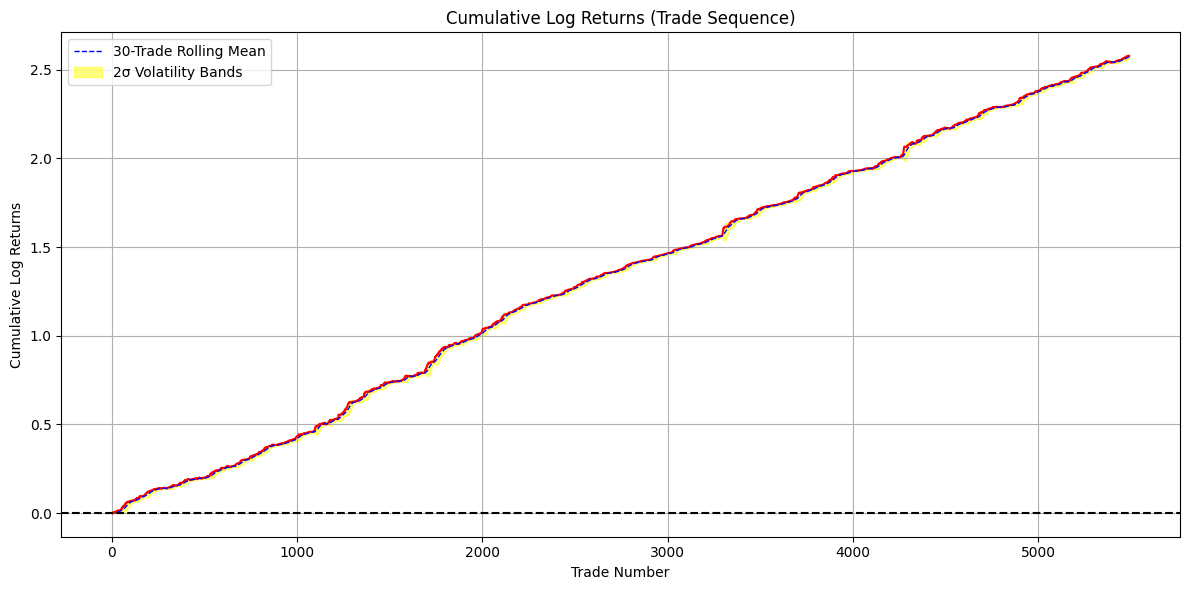

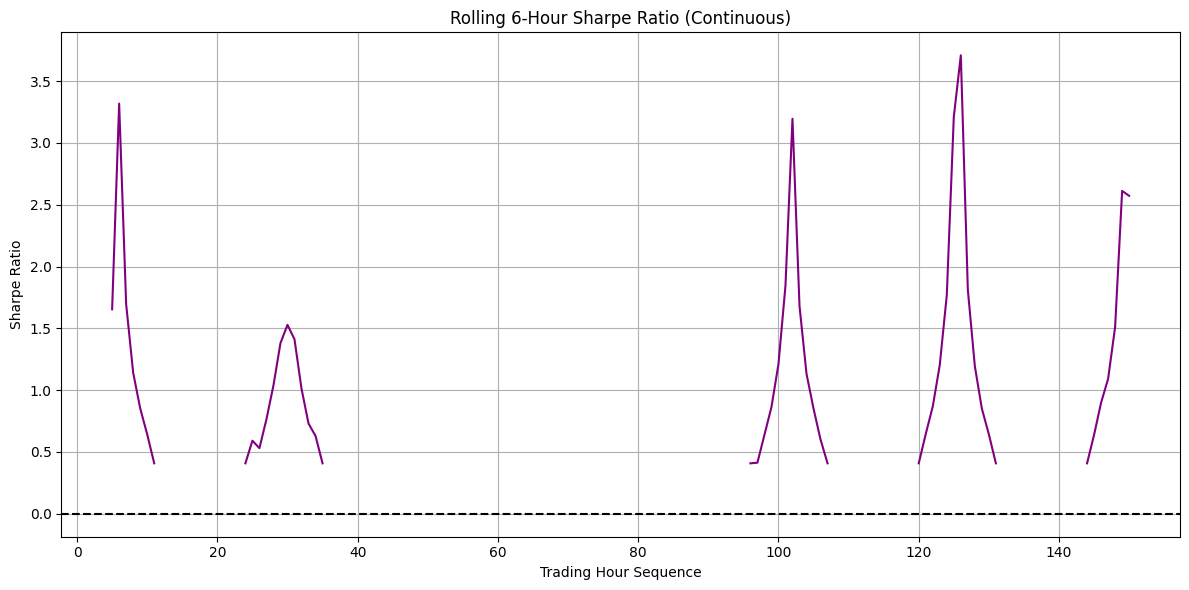

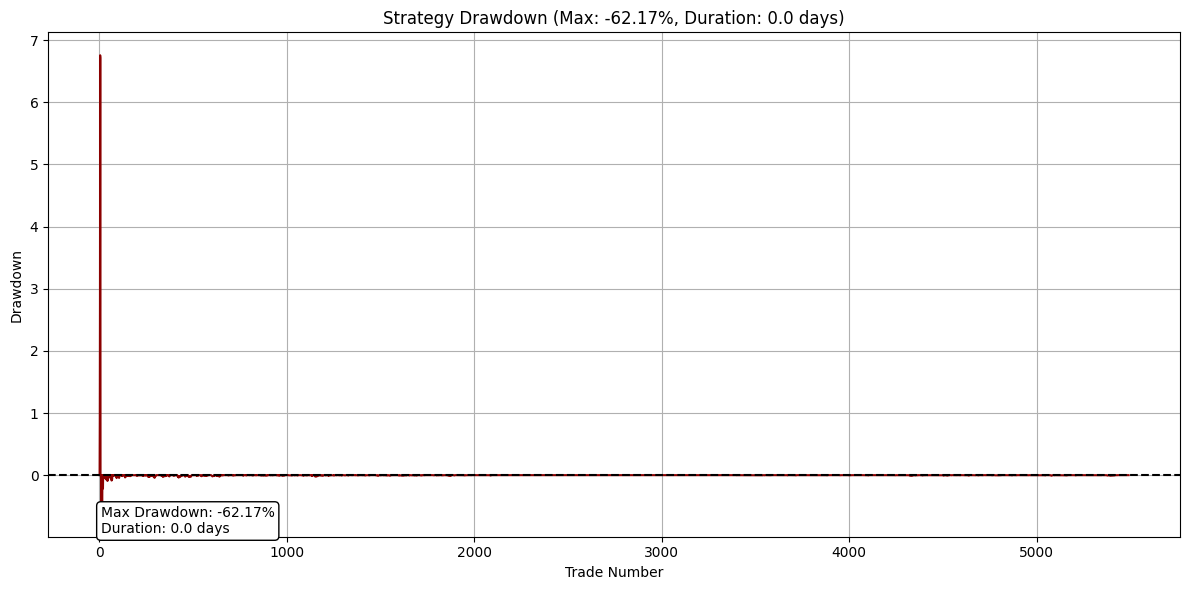

In [11]:
if not results.empty:
        # -------------------------------
        # Performance Validity Checks
        # -------------------------------
        print("\n" + "="*40 + "\nPerformance Validity Analysis\n" + "="*40)

        # Convert to datetime and sort
        results['Exit Time'] = pd.to_datetime(results['Exit Time'])
        results.sort_values('Exit Time', inplace=True)

        # Create trade sequence index
        results['Trade Number'] = range(1, len(results)+1)

        # 1. Gap-Free Cumulative Returns Timeline
        plt.figure(figsize=(12, 6))
        cumulative_log_returns = np.log1p(results['Return']).cumsum()

        # Plot by trade sequence instead of calendar time
        plt.plot(results['Trade Number'], cumulative_log_returns, 
                color='red', linewidth=1.5)
        plt.title('Cumulative Log Returns (Trade Sequence)')
        plt.xlabel('Trade Number')
        plt.ylabel('Cumulative Log Returns')
        plt.grid(True)
        plt.axhline(0, color='black', linestyle='--')

        rolling_window = 30
        rolling_mean = cumulative_log_returns.rolling(rolling_window).mean()
        plt.plot(results['Trade Number'], rolling_mean,
                color='blue', linestyle='--', linewidth=1,
                label=f'{rolling_window}-Trade Rolling Mean')

        rolling_std = cumulative_log_returns.rolling(30).std()
        plt.fill_between(results['Trade Number'],
                        rolling_mean - 2*rolling_std,
                        rolling_mean + 2*rolling_std,
                        color='yellow', alpha=0.5,
                        label='2σ Volatility Bands')

        # Add regime shading
        plt.legend()
        plt.tight_layout()
        plt.show()

        # 2. Continuous Sharpe Ratio
        plt.figure(figsize=(12, 6))
        hourly_returns = results.set_index('Exit Time')['Return'].resample('1h').sum()
        valid_hours = hourly_returns.notna()

        # Create numerical index for continuous plotting
        hour_index = np.arange(len(hourly_returns))[valid_hours]
        rolling_sharpe = hourly_returns[valid_hours].rolling(6).mean() / hourly_returns[valid_hours].rolling(6).std()

        plt.plot(hour_index, rolling_sharpe, 
                color='purple', linewidth=1.5)
        plt.title('Rolling 6-Hour Sharpe Ratio (Continuous)')
        plt.xlabel('Trading Hour Sequence')
        plt.ylabel('Sharpe Ratio')
        plt.axhline(0, color='black', linestyle='--')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # 3. Enhanced Drawdown Analysis
        plt.figure(figsize=(12, 6))
        cumulative_returns = np.exp(cumulative_log_returns) - 1
        peak = cumulative_returns.expanding(min_periods=1).max()
        drawdown = (cumulative_returns - peak)/peak

        # Find maximum drawdown details using datetime index
        max_dd = drawdown.min()
        max_dd_end_idx = drawdown.idxmin()
        max_dd_start_idx = drawdown[:max_dd_end_idx].idxmax()

        # Get actual datetime values from results
        max_dd_start = results.loc[max_dd_start_idx, 'Exit Time']
        max_dd_end = results.loc[max_dd_end_idx, 'Exit Time']

        # Calculate duration in days
        max_dd_duration = (max_dd_end - max_dd_start).total_seconds() / 86400

        # Plot by trade sequence
        plt.plot(results['Trade Number'], drawdown, 
                color='darkred', linewidth=1.5)
        plt.title(f'Strategy Drawdown (Max: {max_dd:.2%}, Duration: {max_dd_duration:.1f} days)')
        plt.xlabel('Trade Number')
        plt.ylabel('Drawdown')
        plt.axhline(0, color='black', linestyle='--')

        max_dd_trade_num = results.loc[max_dd_end_idx, 'Trade Number']
        prev_trade_num = results.loc[max_dd_start_idx, 'Trade Number']

        plt.annotate(f'Max Drawdown: {max_dd:.2%}\nDuration: {max_dd_duration:.1f} days',
                xy=(max_dd_trade_num, max_dd),
                xytext=(max_dd_trade_num - (max_dd_trade_num - prev_trade_num)/2, 
                        max_dd*1.5),
                arrowprops=dict(facecolor='black', arrowstyle='->'),
                bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='black'))

        plt.grid(True)
        plt.tight_layout()
        plt.show()

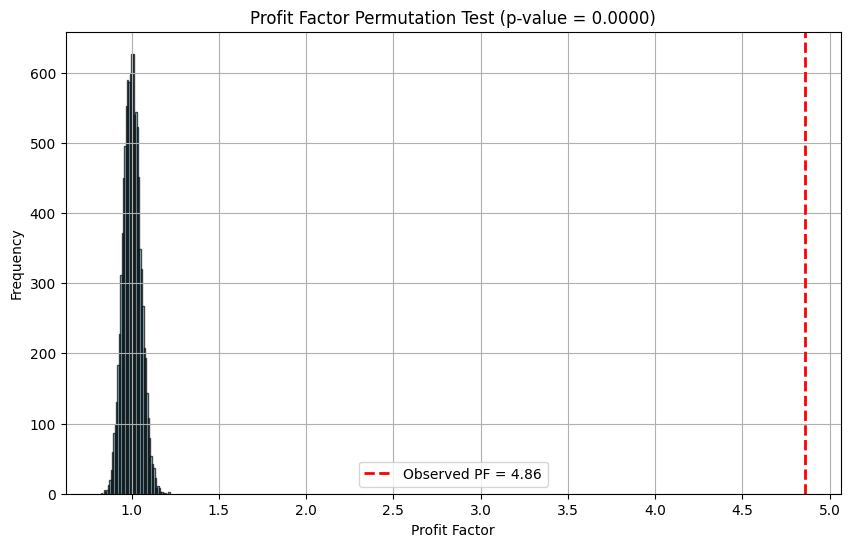


=== Profit Factor Permutation Test ===
Observed Profit Factor: 4.8619
Mean Permutation Profit Factor: 1.0012
P-value: 0.0000
Result: The observed profit factor is statistically significant (p < 0.05)

Profit Factor Permutation Test p-value: 0.0000
Result: Statistically significant profit factor (p < 0.05)


In [12]:
def perform_profit_factor_permutation_test(returns, n_permutations=10000):
    """
    Perform permutation test to evaluate statistical significance of profit factor
    
    Parameters:
    - returns: Array of trade returns
    - n_permutations: Number of permutations for the test
    
    Returns:
    - p-value of the observed profit factor
    """
    # Calculate the observed profit factor
    observed_pf = calculate_profit_factor(returns)
    
    # Initialize array to store permutation results
    permutation_pfs = np.zeros(n_permutations)
    
    # Perform permutation test by randomly flipping signs of returns
    np.random.seed(21)
    for i in range(n_permutations):
        # Generate random signs (-1 or 1) for each return
        random_signs = np.random.choice([-1, 1], size=len(returns))
        # Apply random signs to returns
        permuted_returns = returns * random_signs
        # Calculate profit factor for permuted returns
        permutation_pfs[i] = calculate_profit_factor(permuted_returns)
    
    # Calculate p-value: proportion of permuted PFs >= observed PF
    p_value = np.mean(permutation_pfs >= observed_pf)
    
    # Plot histogram of permutation results
    plt.figure(figsize=(10, 6))
    plt.hist(permutation_pfs, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    plt.axvline(observed_pf, color='red', linestyle='dashed', linewidth=2, label=f'Observed PF = {observed_pf:.2f}')
    plt.title(f'Profit Factor Permutation Test (p-value = {p_value:.4f})')
    plt.xlabel('Profit Factor')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Print summary of permutation test
    print("\n=== Profit Factor Permutation Test ===")
    print(f"Observed Profit Factor: {observed_pf:.4f}")
    print(f"Mean Permutation Profit Factor: {np.mean(permutation_pfs):.4f}")
    print(f"P-value: {p_value:.4f}")
    
    if p_value < 0.05:
        print("Result: The observed profit factor is statistically significant (p < 0.05)")
    else:
        print("Result: The observed profit factor is NOT statistically significant (p >= 0.05)")
    
    return p_value

# Extract returns array
returns_array = results['Return'].values

# Run permutation test (e.g., 10,000 permutations)
p_value = perform_profit_factor_permutation_test(returns_array, n_permutations=10000)

# Display p-value
print(f"\nProfit Factor Permutation Test p-value: {p_value:.4f}")
if p_value < 0.05:
    print("Result: Statistically significant profit factor (p < 0.05)")
else:
    print("Result: Profit factor not statistically significant (p >= 0.05)")


Return Distribution

--- Return Statistics ---
|        |     count |   mean |    std |     min |     10% |    25% |    50% |    75% |    90% |    99% |   99.9% |   99.99% |    max |
|:-------|----------:|-------:|-------:|--------:|--------:|-------:|-------:|-------:|-------:|-------:|--------:|---------:|-------:|
| Return | 5491.0000 | 0.0005 | 0.0012 | -0.0084 | -0.0005 | 0.0000 | 0.0000 | 0.0008 | 0.0017 | 0.0053 |  0.0099 |   0.0157 | 0.0168 |

--- Worst Outcomes ---
|        |   Worst 5.00% |   Worst 1.00% |   Worst 0.10% |   Worst 0.01% |
|:-------|--------------:|--------------:|--------------:|--------------:|
| Return |       -0.0008 |       -0.0017 |       -0.0028 |       -0.0057 |


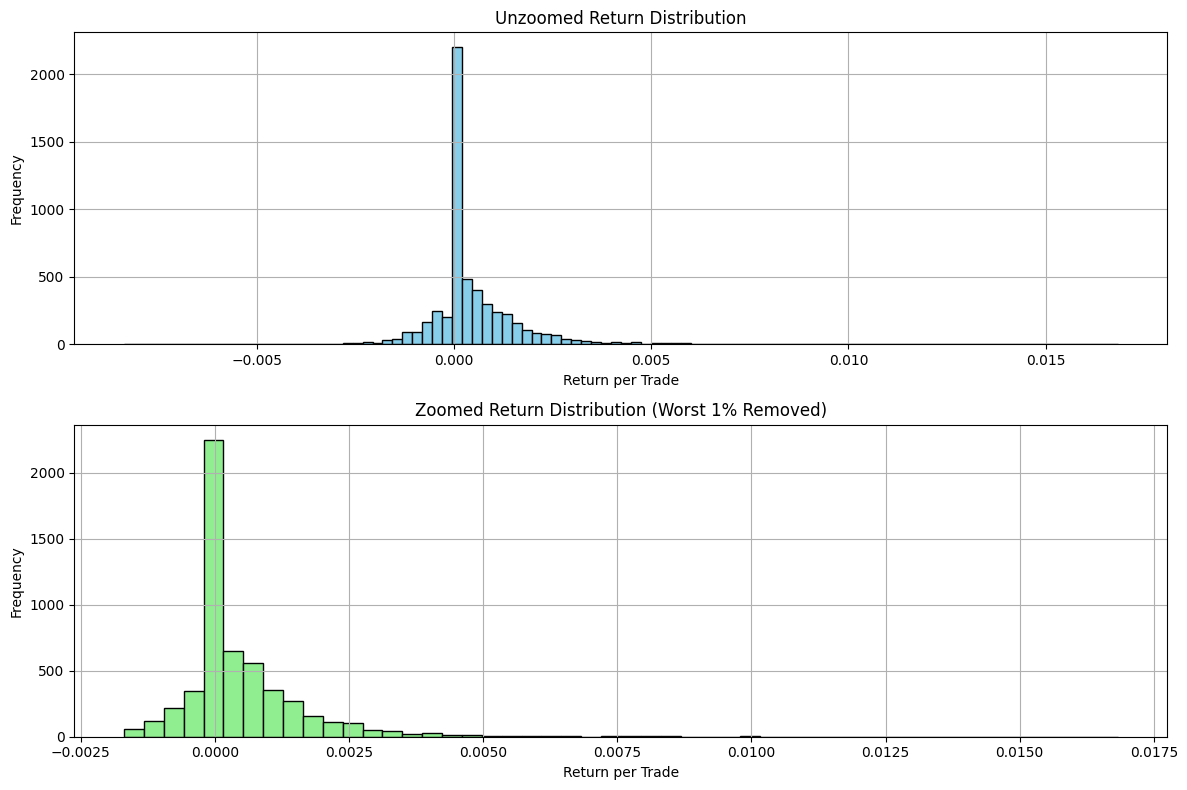

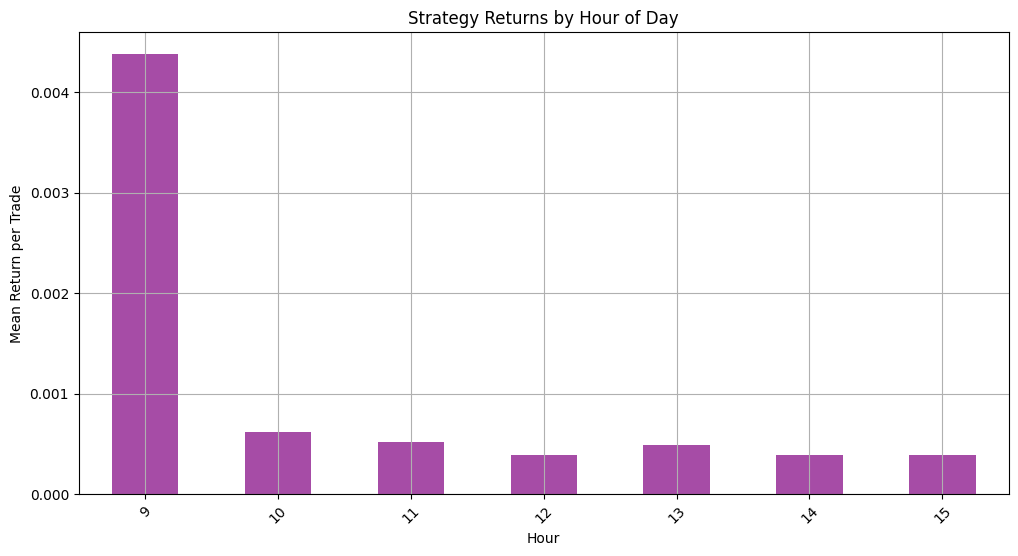

C:\Users\Administrator\AppData\Local\Temp\ipykernel_54624\853235495.py:51: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  results['Day'] = results['DateTime'].dt.to_period('D')


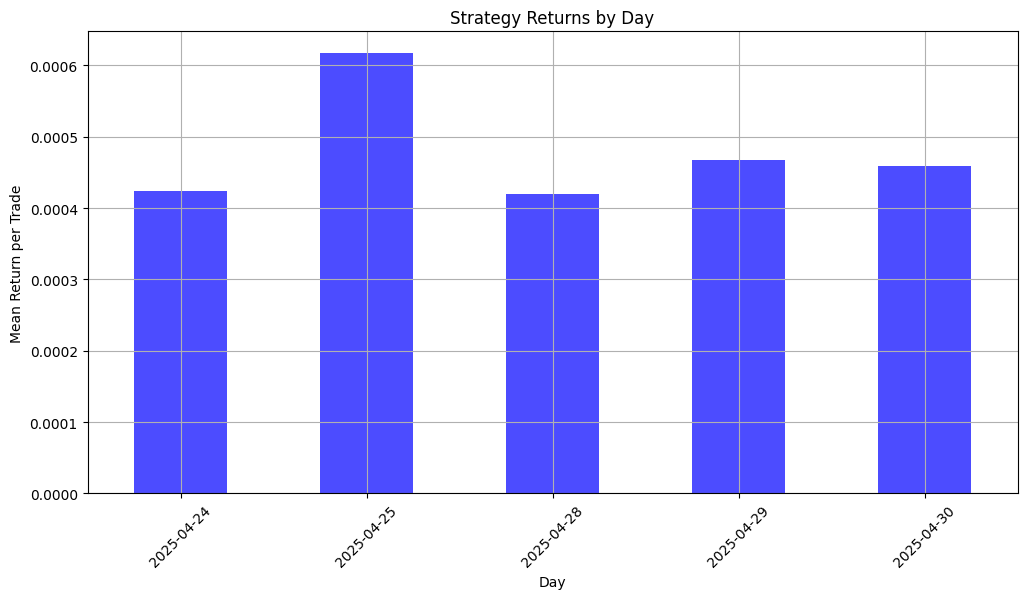


Kelly Criterion

--- 1 Day Simulations ---

Kelly Fraction: 100% for 1 Day window
|    | Kelly %   |    count |    mean |   std |     min |      1% |     10% |     25% |     50% |     75% |     90% |     99% |     max |
|---:|:----------|---------:|--------:|------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|
|  0 | 100%      | 10000.00 | 1750.81 | 75.49 | 1495.06 | 1586.11 | 1656.47 | 1698.43 | 1747.76 | 1800.86 | 1849.69 | 1934.89 | 2093.90 |


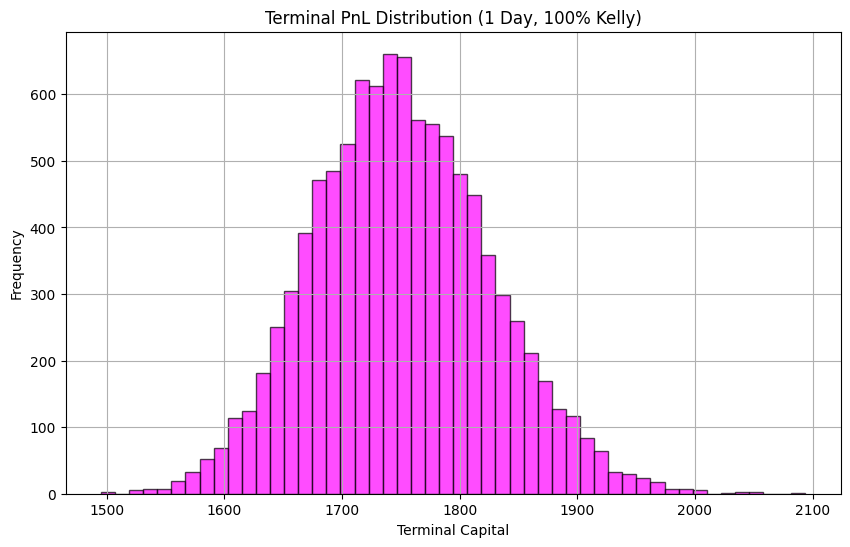

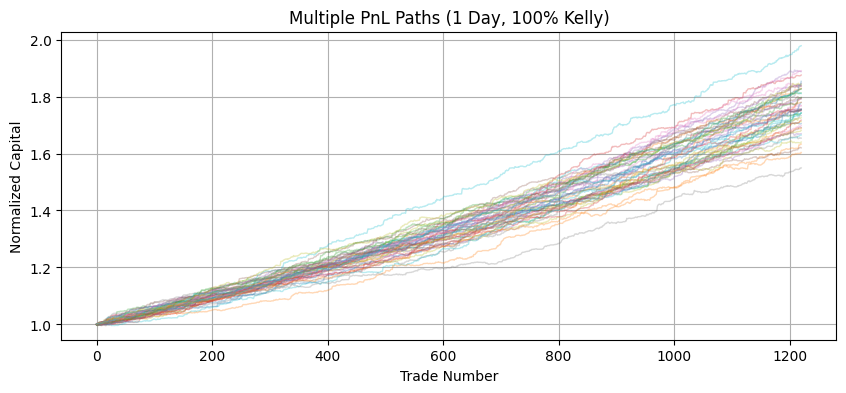


Kelly Fraction: 50% for 1 Day window
|    | Kelly %   |    count |    mean |   std |     min |      1% |     10% |     25% |     50% |     75% |     90% |     99% |     max |
|---:|:----------|---------:|--------:|------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|
|  0 | 50%       | 10000.00 | 1323.23 | 28.52 | 1223.02 | 1259.70 | 1287.35 | 1303.56 | 1322.38 | 1342.33 | 1360.41 | 1391.48 | 1447.56 |


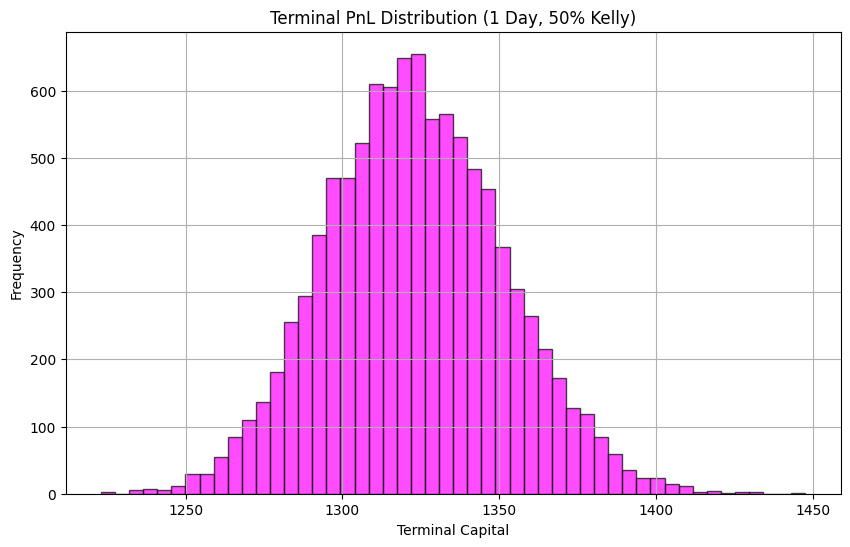

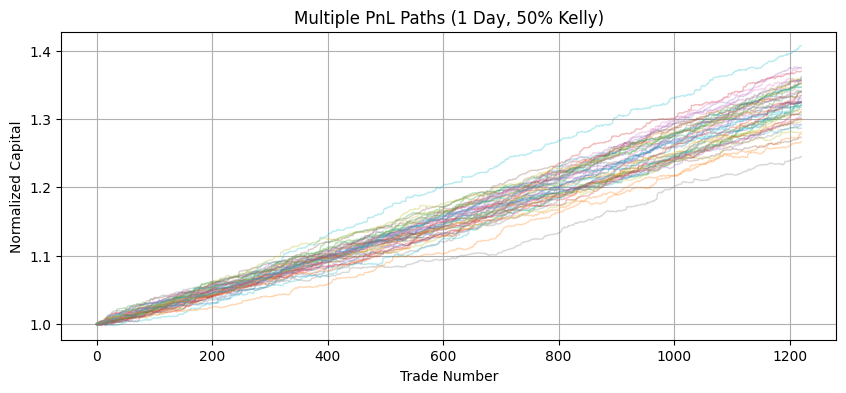


Kelly Fraction: 30% for 1 Day window
|    | Kelly %   |    count |    mean |   std |     min |      1% |     10% |     25% |     50% |     75% |     90% |     99% |     max |
|---:|:----------|---------:|--------:|------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|
|  0 | 30%       | 10000.00 | 1183.00 | 15.30 | 1128.45 | 1148.64 | 1163.70 | 1172.48 | 1182.61 | 1193.28 | 1202.91 | 1219.33 | 1248.59 |


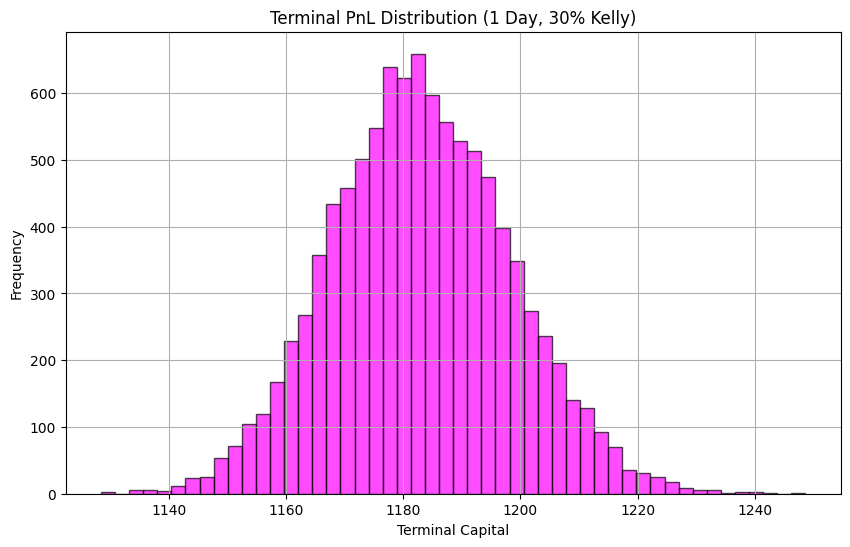

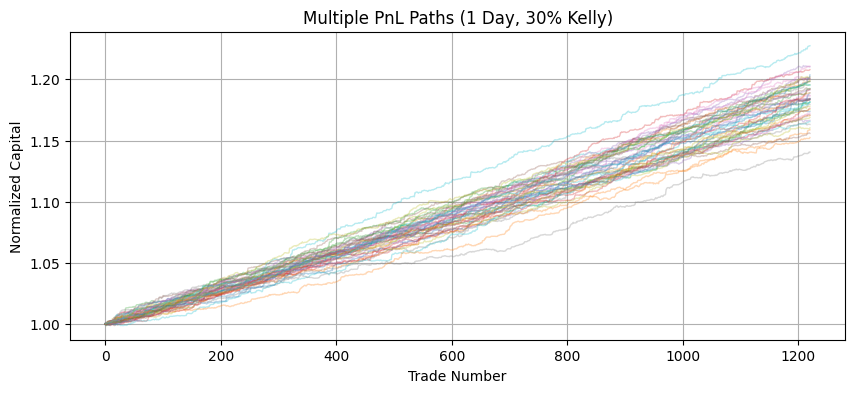


--- 3 Days Simulations ---

Kelly Fraction: 100% for 3 Days window
|    | Kelly %   |    count |    mean |    std |     min |      1% |     10% |     25% |     50% |     75% |     90% |     99% |     max |
|---:|:----------|---------:|--------:|-------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|
|  0 | 100%      | 10000.00 | 4763.13 | 317.86 | 3595.13 | 4083.18 | 4365.71 | 4545.31 | 4748.22 | 4970.42 | 5173.46 | 5569.44 | 6118.59 |


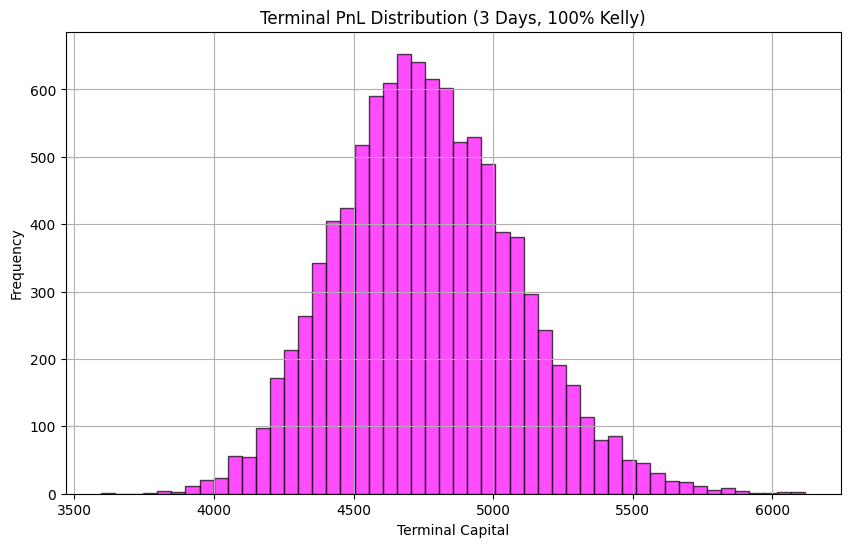

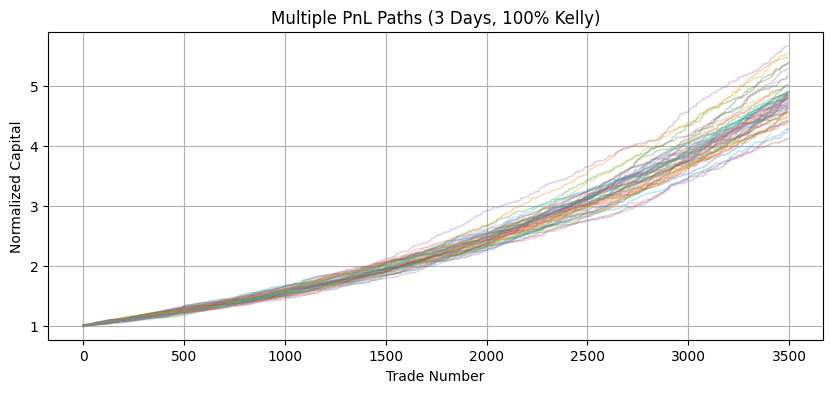


Kelly Fraction: 50% for 3 Days window
|    | Kelly %   |    count |    mean |   std |     min |      1% |     10% |     25% |     50% |     75% |     90% |     99% |     max |
|---:|:----------|---------:|--------:|------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|
|  0 | 50%       | 10000.00 | 2182.63 | 72.76 | 1897.09 | 2021.79 | 2090.73 | 2133.26 | 2180.39 | 2230.90 | 2276.08 | 2361.77 | 2475.48 |


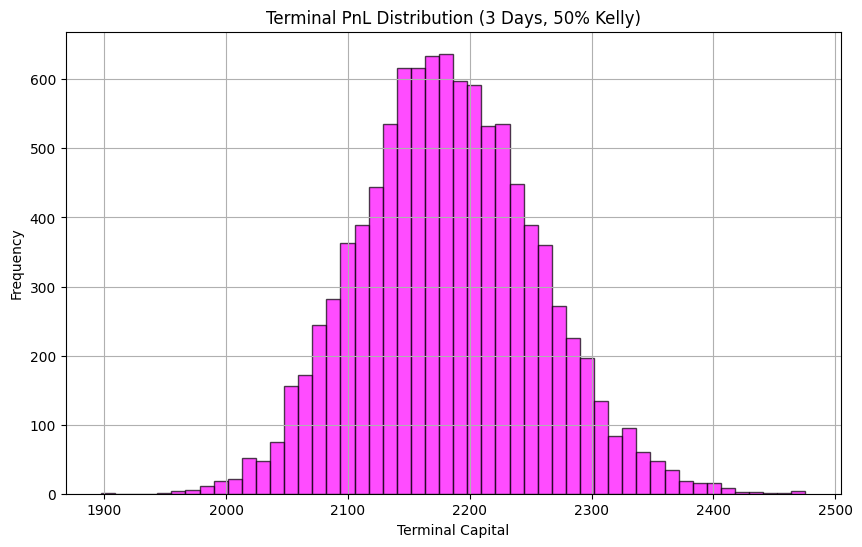

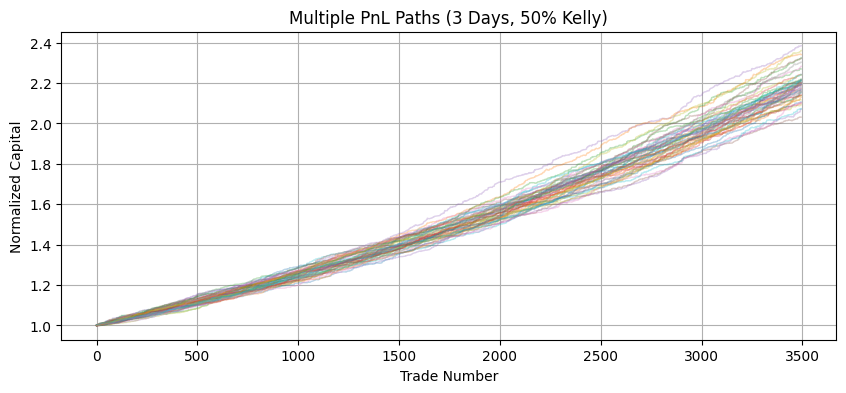


Kelly Fraction: 30% for 3 Days window
|    | Kelly %   |    count |    mean |   std |     min |      1% |     10% |     25% |     50% |     75% |     90% |     99% |     max |
|---:|:----------|---------:|--------:|------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|
|  0 | 30%       | 10000.00 | 1597.34 | 31.94 | 1468.61 | 1525.81 | 1556.82 | 1575.76 | 1596.56 | 1618.66 | 1638.26 | 1675.03 | 1722.96 |


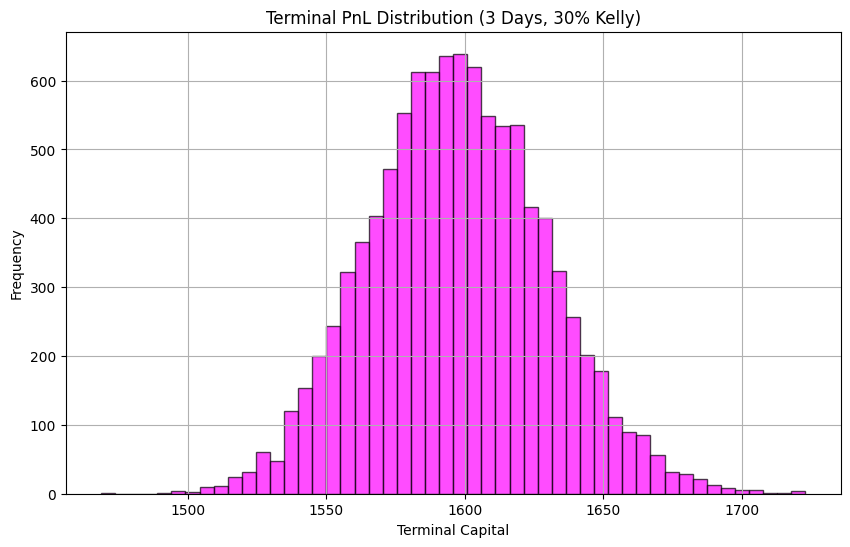

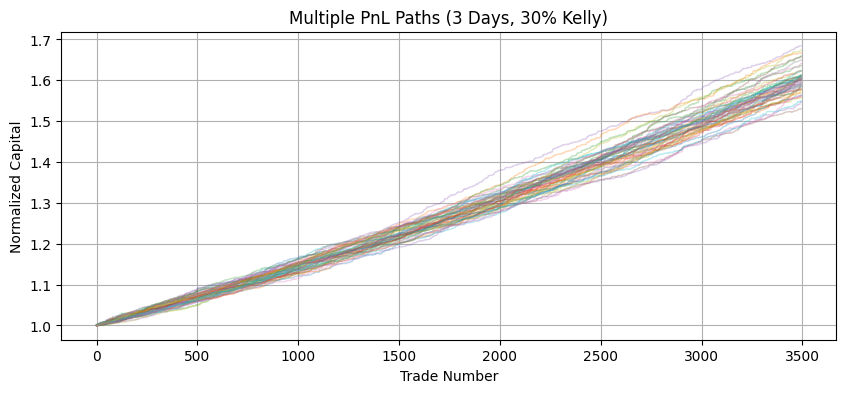


--- Full Dataset Simulations ---

Kelly Fraction: 100% for Full Dataset window
|    | Kelly %   |    count |     mean |     std |     min |       1% |      10% |      25% |      50% |      75% |      90% |      99% |      max |
|---:|:----------|---------:|---------:|--------:|--------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|
|  0 | 100%      | 10000.00 | 13226.36 | 1222.38 | 9446.15 | 10677.25 | 11688.78 | 12380.82 | 13163.27 | 13999.39 | 14819.07 | 16340.42 | 18375.42 |


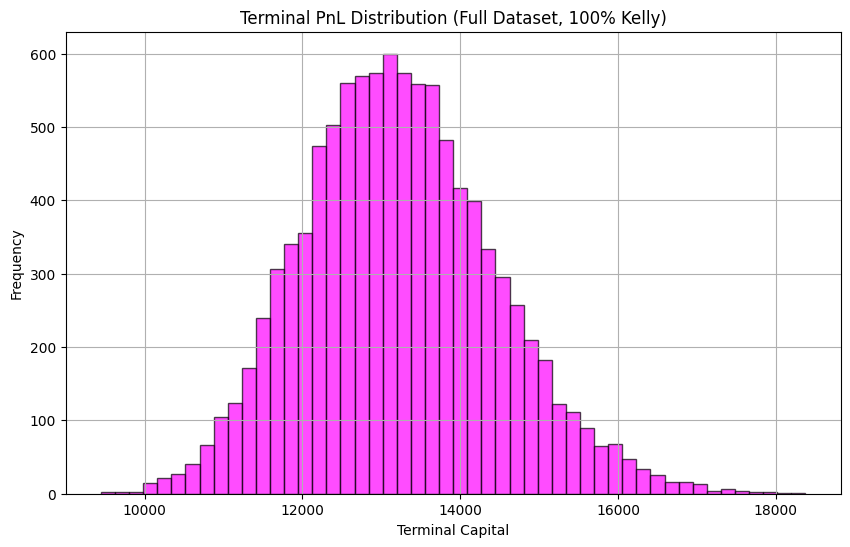

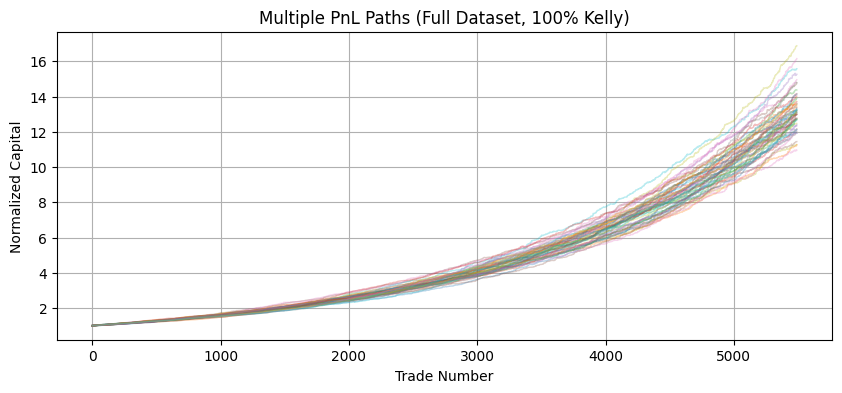


Kelly Fraction: 50% for Full Dataset window
|    | Kelly %   |    count |    mean |    std |     min |      1% |     10% |     25% |     50% |     75% |     90% |     99% |     max |
|---:|:----------|---------:|--------:|-------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|
|  0 | 50%       | 10000.00 | 3637.31 | 167.86 | 3076.77 | 3271.07 | 3422.53 | 3522.54 | 3632.37 | 3746.10 | 3854.52 | 4047.57 | 4292.69 |


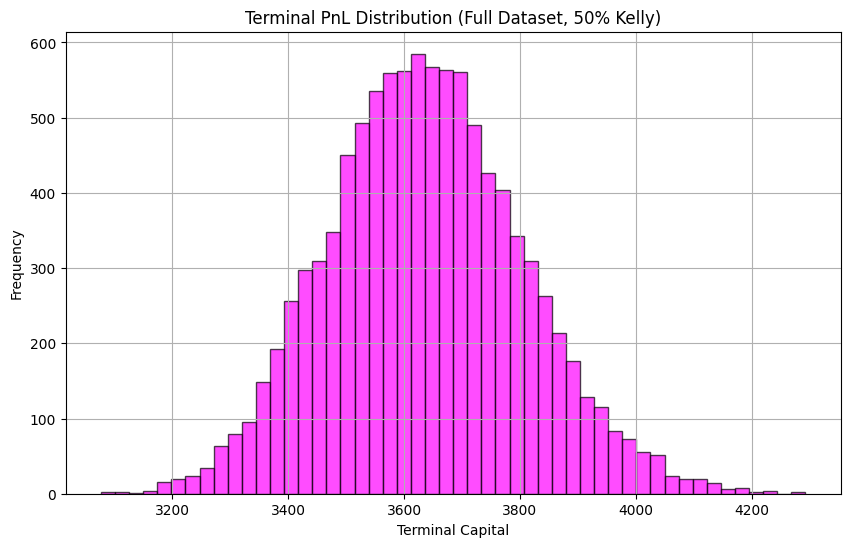

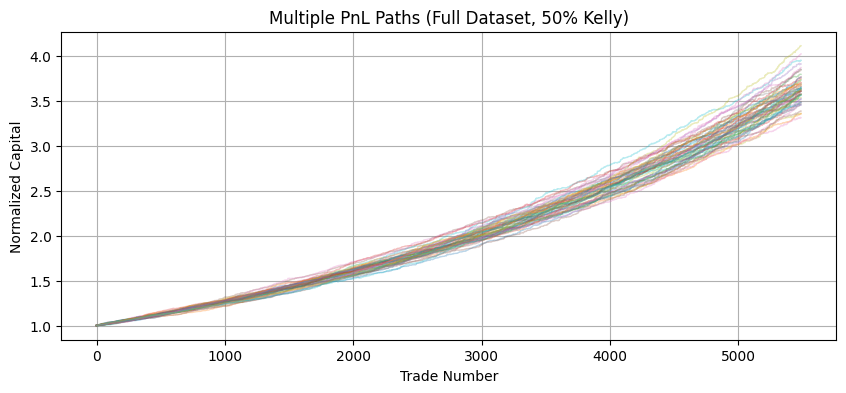


Kelly Fraction: 30% for Full Dataset window
|    | Kelly %   |    count |    mean |   std |     min |      1% |     10% |     25% |     50% |     75% |     90% |     99% |     max |
|---:|:----------|---------:|--------:|------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|
|  0 | 30%       | 10000.00 | 2170.12 | 60.08 | 1963.22 | 2036.67 | 2092.82 | 2129.29 | 2168.90 | 2209.40 | 2247.57 | 2314.43 | 2397.65 |


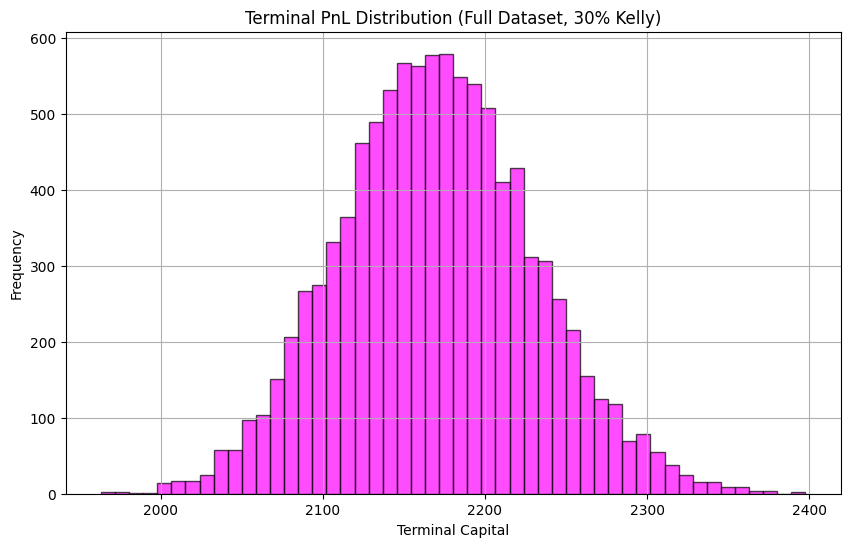

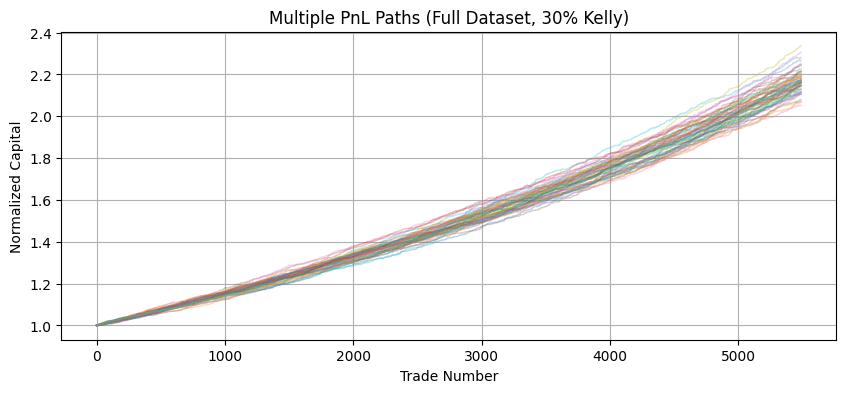


Trade Entry/Exit Analysis


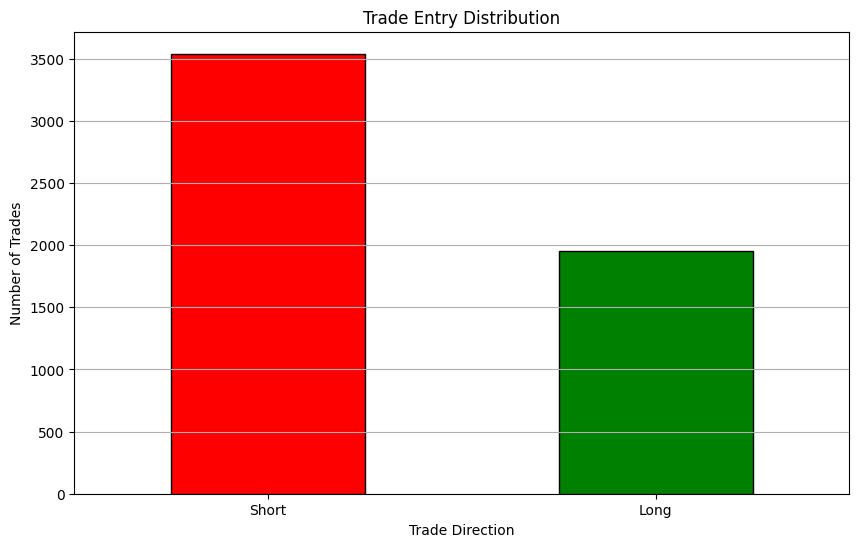

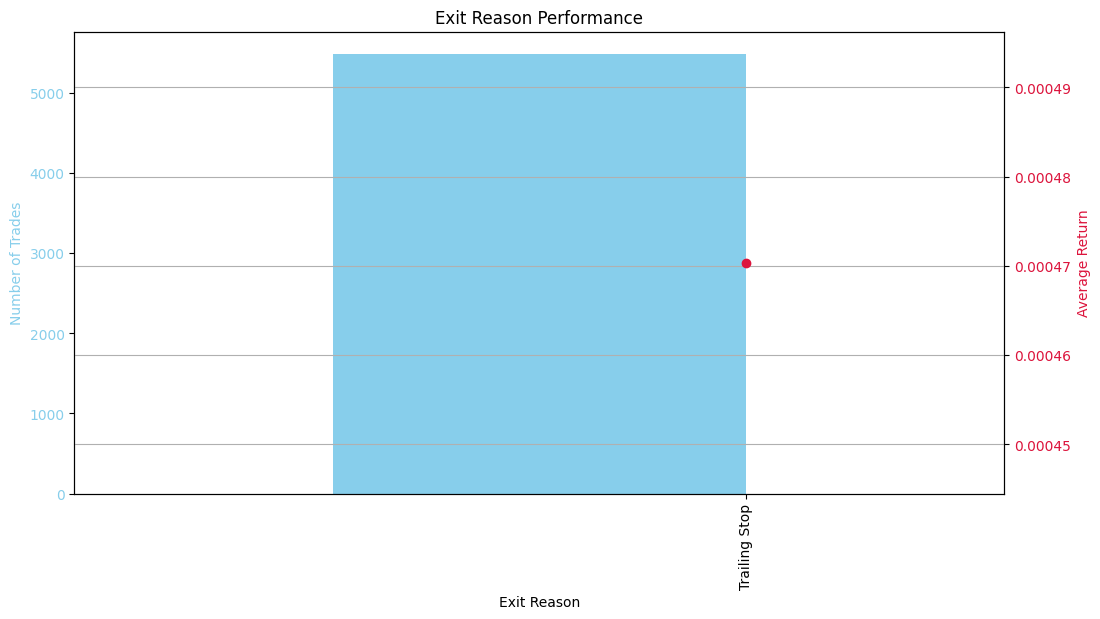


--- Trade Direction Summary ---
|       |   Short |   Long |
|:------|--------:|-------:|
| count |    3540 |   1951 |

--- Exit Reason Performance ---
| Exit Reason   |   Count |   Avg Return |
|:--------------|--------:|-------------:|
| Trailing Stop |    5491 |       0.0005 |


In [13]:
if not results.empty:
    # -------------------------------
    # Return Distribution
    # -------------------------------
    print("\n" + "="*40 + "\nReturn Distribution\n" + "="*40)
    
    # Return Statistics
    print("\n--- Return Statistics ---")
    stats_df = results['Return'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 0.999, 0.9999])
    print(stats_df.to_frame().T.to_markdown(floatfmt=".4f"))
    
    # Worst Outcomes Table
    print("\n--- Worst Outcomes ---")
    worst_percentiles = [0.05, 0.01, 0.001, 0.0001]
    worst_returns = results['Return'].quantile(worst_percentiles).to_frame().T
    worst_returns.columns = [f'Worst {p*100:.2f}%' for p in worst_percentiles]
    print(worst_returns.to_markdown(floatfmt=".4f"))
    
    # Histograms for Return Distributions
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.hist(results['Return'], bins=100, color='skyblue', edgecolor='black')
    plt.title('Unzoomed Return Distribution')
    plt.xlabel('Return per Trade')
    plt.ylabel('Frequency')
    plt.grid(True)
    
    plt.subplot(2, 1, 2)
    zoomed_data = results[results['Return'] > results['Return'].quantile(0.01)]
    plt.hist(zoomed_data['Return'], bins=50, color='lightgreen', edgecolor='black')
    plt.title('Zoomed Return Distribution (Worst 1% Removed)')
    plt.xlabel('Return per Trade')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Hourly Returns Analysis
    hourly_returns = results.groupby(results['DateTime'].dt.hour)['Return'].mean()
    
    plt.figure(figsize=(12, 6))
    hourly_returns.plot(kind='bar', color='purple', alpha=0.7)
    plt.title('Strategy Returns by Hour of Day')
    plt.xlabel('Hour')
    plt.ylabel('Mean Return per Trade')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()
    
    # Daily Returns Analysis
    results['Day'] = results['DateTime'].dt.to_period('D')
    daily_returns = results.groupby('Day')['Return'].mean()
    
    plt.figure(figsize=(12, 6))
    daily_returns.plot(kind='bar', color='blue', alpha=0.7)
    plt.title('Strategy Returns by Day')
    plt.xlabel('Day')
    plt.ylabel('Mean Return per Trade')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()
    
    # -------------------------------
    # Kelly Criterion Analysis
    # -------------------------------
    print("\n" + "="*40 + "\nKelly Criterion\n" + "="*40)
    
    def monte_carlo_kelly(returns, kelly_fraction=1.0, n_sims=10000):
        np.random.seed(69)
        all_terminal = []
        for _ in range(n_sims):
            sampled_returns = np.random.choice(returns, size=len(returns), replace=True)
            capital = 1000
            for ret in sampled_returns:
                capital *= (1 + kelly_fraction * ret)
            all_terminal.append(capital)
        return pd.Series(all_terminal)
    
    def plot_multiple_pnl_paths(returns, kelly_fraction=1.0, num_paths=100, label=''):
        plt.figure(figsize=(10, 4))
        for _ in range(num_paths):
            path = np.cumprod(1 + kelly_fraction * np.random.choice(returns, size=len(returns)))
            plt.plot(path, lw=1, alpha=0.3)  # thin lines with transparency
        plt.title(f'Multiple PnL Paths ({label}, {int(kelly_fraction*100)}% Kelly)')
        plt.xlabel('Trade Number')
        plt.ylabel('Normalized Capital')
        plt.grid(True)
        plt.show()
    
    # Adjust time windows for 1-minute data
    kelly_configs = [
        ('1 Day', pd.Timedelta(days=1)),
        ('3 Days', pd.Timedelta(days=3)),
        ('Full Dataset', pd.Timedelta(days=7))
    ]
    
    end_date_dt = results['DateTime'].max()
    
    for label, time_delta in kelly_configs:
        print(f"\n--- {label} Simulations ---")
        # Calculate the start date for the window
        start_date_dt = end_date_dt - time_delta
        subset = results[results['DateTime'] > start_date_dt]
        
        if subset.empty:
            print(f"No data for {label} window")
            continue
            
        returns = subset['Return'].values
        
        for fraction in [1.0, 0.5, 0.3]:
            terminal_pnl = monte_carlo_kelly(returns, kelly_fraction=fraction)
            
            # Stats Table for Terminal PnL
            stats_table = terminal_pnl.describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]).to_frame().T
            stats_table.insert(0, 'Kelly %', f'{int(fraction*100)}%')
            print(f"\nKelly Fraction: {int(fraction*100)}% for {label} window")
            print(stats_table.to_markdown(floatfmt=".2f"))
            
            # Histogram of Terminal Capital distribution
            plt.figure(figsize=(10, 6))
            plt.hist(terminal_pnl, bins=50, alpha=0.7, color='magenta', edgecolor='black')
            plt.title(f'Terminal PnL Distribution ({label}, {int(fraction*100)}% Kelly)')
            plt.xlabel('Terminal Capital')
            plt.ylabel('Frequency')
            plt.grid(True)
            plt.show()
    
            # Plot Multiple Simulation Paths (PnL Curves)
            plot_multiple_pnl_paths(returns, kelly_fraction=fraction, num_paths=50, label=label)
    
    # -------------------------------
    # Trade Entry and Exit Analysis
    # -------------------------------
    print("\n" + "="*40 + "\nTrade Entry/Exit Analysis\n" + "="*40)
    
    # 1. Trade Entry Distribution
    plt.figure(figsize=(10, 6))
    entry_counts = results['Direction'].value_counts()
    colors = ['green' if dir == 'Long' else 'red' for dir in entry_counts.index]
    entry_counts.plot(kind='bar', color=colors, edgecolor='black')
    plt.title('Trade Entry Distribution')
    plt.xlabel('Trade Direction')
    plt.ylabel('Number of Trades')
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.show()

    # 2. Exit Reason Analysis (Dual-axis Plot)
    exit_reasons = results[results['Exit Reason'].isin(['Trailing Stop', 'Time-based', 'End of Data'])]
    
    plt.figure(figsize=(12, 6))
    
    # Bar plot for counts
    ax1 = plt.gca()
    reason_counts = exit_reasons['Exit Reason'].value_counts()
    reason_counts.plot(kind='bar', color='skyblue', ax=ax1, width=0.4, position=1)
    ax1.set_ylabel('Number of Trades', color='skyblue')
    ax1.tick_params(axis='y', labelcolor='skyblue')
    
    # Line plot for average returns
    ax2 = ax1.twinx()
    avg_returns = exit_reasons.groupby('Exit Reason')['Return'].mean()
    avg_returns.plot(kind='line', color='crimson', marker='o', ax=ax2, linewidth=2)
    ax2.set_ylabel('Average Return', color='crimson')
    ax2.tick_params(axis='y', labelcolor='crimson')
    
    plt.title('Exit Reason Performance')
    ax1.set_xlabel('Exit Reason')
    plt.xticks(rotation=0)
    plt.grid(True)
    plt.show()

    # Print numerical summary
    print("\n--- Trade Direction Summary ---")
    print(entry_counts.to_frame().T.to_markdown())
    
    print("\n--- Exit Reason Performance ---")
    summary_df = pd.DataFrame({
        'Count': reason_counts,
        'Avg Return': avg_returns
    })
    print(summary_df.to_markdown(floatfmt=("", ".0f", ".4f")))
else:
    print("No trades found with the given strategy.")

In [14]:
def run_walkforward_analysis(tickers, start_date, end_date, use_trailing_stop=True, exit_bars=60):
    """
    Run walk-forward analysis of the HedgeScalp strategy
    
    Parameters:
    - tickers: List of stock symbols
    - start_date: Starting date for backtest
    - end_date: Ending date for backtest
    - use_trailing_stop: Whether to use trailing stops
    - exit_bars: Number of bars (minutes) before time-based exit
    
    Returns:
    - DataFrame of all out-of-sample trades
    """
    # Convert dates to datetime if they're strings
    if not isinstance(start_date, datetime):
        start_date = datetime.combine(start_date, datetime.min.time())
    if not isinstance(end_date, datetime):
        end_date = datetime.combine(end_date, datetime.min.time())
    
    # For 7 days of data: use 5 days for training, 2 days for testing
    train_start = start_date
    train_end = start_date + timedelta(days=5)
    test_start = train_end
    test_end = end_date
    
    print(f"\n=== Processing Walk-Forward Window ===")
    print(f"Training: {train_start.strftime('%Y-%m-%d')} to {train_end.strftime('%Y-%m-%d')}")
    print(f"Testing:  {test_start.strftime('%Y-%m-%d')} to {test_end.strftime('%Y-%m-%d')}")
    
    # Start storing results
    all_oos_trades = []
    
    # Process each ticker
    for ticker in tqdm(tickers, desc="Processing Tickers"):
        try:
            data = get_historical_data(ticker, train_start - timedelta(days=1),
                                        test_end + timedelta(days=1))
            
            if data.empty:
                continue
            
            # Convert timezone-aware index to naive for comparison
            data.index = data.index.tz_localize(None)
            
            # Split into train and test sets
            train_data = data[data.index < train_end]
            test_data = data[(data.index >= test_start) & (data.index < test_end)]
            
            if train_data.empty or test_data.empty:
                continue
            
            # Apply strategy to training data (for analysis only)
            train_data = apply_strategy(train_data)
            
            # Apply strategy to the test data
            test_data = apply_strategy(test_data)
            
            # Skip if no signals were generated in test set
            if 'Signal' not in test_data.columns or test_data['Signal'].abs().sum() == 0:
                continue
            
            # Initialize tracking for this ticker
            active_trades = {}
            ticker_trades = []
            
            # Process day by day in test data
            for day, day_data in test_data.groupby(test_data.index.date):
                # Track VWAP components for this day
                cumul_tpv = 0
                cumul_vol = 0
                
                # Process each bar (minute) during the day
                for t, row in day_data.iterrows():
                    # Update VWAP for this bar
                    tp = (row['High'] + row['Low'] + row['Close']) / 3
                    cumul_tpv += tp * row['Volume']
                    cumul_vol += row['Volume']
                    
                    vwap = cumul_tpv / cumul_vol if cumul_vol > 0 else row['Close']
                    
                    # Check trailing stops for active trades
                    trades_to_close = []
                    for entry_time, trade in active_trades.items():
                        if use_trailing_stop:
                            # For long positions, trailing stop is previous candle's close
                            if trade['Direction'] == 'Long':
                                prev_idx = day_data.index.get_loc(t) - 1
                                if prev_idx > 0:
                                    new_stop = day_data['Close'].iloc[prev_idx]
                                    if trade['Stop'] is None or new_stop > trade['Stop']:
                                        active_trades[entry_time]['Stop'] = new_stop
                                        
                                    # Check if current price hits trailing stop
                                    if row['Low'] <= trade['Stop']:
                                        trade['Exit Price'] = trade['Stop']
                                        trade['Exit Time'] = t
                                        trade['Exit Reason'] = 'Trailing Stop'
                                        
                                        # Calculate return
                                        ret = (trade['Exit Price'] - trade['Entry Price']) / trade['Entry Price']
                                        trade['Return'] = ret
                                        trade['Return %'] = ret * 100
                                        
                                        ticker_trades.append(trade)
                                        trades_to_close.append(entry_time)
                            
                            # For short positions, trailing stop is previous candle's open
                            elif trade['Direction'] == 'Short':
                                prev_idx = day_data.index.get_loc(t) - 1
                                if prev_idx > 0:
                                    new_stop = day_data['Open'].iloc[prev_idx]
                                    if trade['Stop'] is None or new_stop < trade['Stop']:
                                        active_trades[entry_time]['Stop'] = new_stop
                                        
                                    # Check if current price hits trailing stop
                                    if row['High'] >= trade['Stop']:
                                        trade['Exit Price'] = trade['Stop']
                                        trade['Exit Time'] = t
                                        trade['Exit Reason'] = 'Trailing Stop'
                                        
                                        # Calculate return
                                        ret = (trade['Entry Price'] - trade['Exit Price']) / trade['Entry Price']
                                        trade['Return'] = ret
                                        trade['Return %'] = ret * 100
                                        
                                        ticker_trades.append(trade)
                                        trades_to_close.append(entry_time)
                        
                        # Time-based exit (after exit_bars minutes)
                        time_passed = (t - entry_time).total_seconds() / 60
                        if time_passed >= exit_bars:
                            trade['Exit Price'] = row['Close']
                            trade['Exit Time'] = t
                            trade['Exit Reason'] = 'Time-based'
                            
                            if trade['Direction'] == 'Long':
                                ret = (trade['Exit Price'] - trade['Entry Price']) / trade['Entry Price']
                            else:
                                ret = (trade['Entry Price'] - trade['Exit Price']) / trade['Entry Price']
                                
                            trade['Return'] = ret
                            trade['Return %'] = ret * 100
                            
                            ticker_trades.append(trade)
                            trades_to_close.append(entry_time)
                    
                    # Remove closed trades
                    for entry_time in trades_to_close:
                        del active_trades[entry_time]
                    
                    # Process new entry signals when not in a position
                    if len(active_trades) == 0 and row['Signal'] != 0:
                        direction = 'Long' if row['Signal'] == 1 else 'Short'

                        position_size = 1000  # $10,000 per trade
                        shares = position_size // row['Close']
                        
                        # Set initial trailing stop
                        initial_stop = None
                        prev_idx = day_data.index.get_loc(t) - 1 if t in day_data.index else -1
                        if prev_idx > 0:
                            if direction == 'Long':
                                initial_stop = day_data['Close'].iloc[prev_idx]
                            else:
                                initial_stop = day_data['Open'].iloc[prev_idx]

                        if direction == 'Short':
                            entry_fee = calculate_regulatory_fees(row['Close'], shares)
                            # Store fee to deduct from returns later
                            fee_impact = entry_fee / (row['Close'] * shares)
                        else:
                            fee_impact = 0
                        
                        active_trades[t] = {
                            'Symbol': ticker,
                            'DateTime': t,
                            'Direction': direction,
                            'Entry Price': row['Close'],
                            'Shares': shares,
                            'Fee Impact': fee_impact,
                            'Stop': initial_stop,
                            'VWAP': vwap,
                            'Volume': row['Volume'],
                            'Vol_MA': row['Vol_MA']
                        }
            
            # Close any remaining open trades at the end of data
            for entry_time, trade in active_trades.items():
                last_row = test_data.iloc[-1]
                trade['Exit Price'] = last_row['Close'] 
                trade['Exit Time'] = test_data.index[-1]
                trade['Exit Reason'] = 'End of Data'

                if trade['Direction'] == 'Long':
                    # Apply fees for long exits
                    exit_fee = calculate_regulatory_fees(trade['Exit Price'], trade['Shares'])
                    fee_impact = exit_fee / (trade['Entry Price'] * trade['Shares'])
                else:
                    fee_impact = trade['Fee Impact']
                
                if trade['Direction'] == 'Long':
                    ret = (trade['Exit Price'] - trade['Entry Price']) / trade['Entry Price']
                else:
                    ret = (trade['Entry Price'] - trade['Exit Price']) / trade['Entry Price']
                    
                trade['Return'] = ret
                trade['Return %'] = ret * 100
                
                ticker_trades.append(trade)
            
            # Add ticker trades to overall out-of-sample results
            all_oos_trades.extend(ticker_trades)
            
            # Print ticker performance summary
            if ticker_trades:
                ticker_returns = [t['Return'] for t in ticker_trades]
                total_pnl = sum(ticker_returns)
                num_trades = len(ticker_returns)
                win_rate = sum(1 for r in ticker_returns if r > 0) / num_trades if num_trades > 0 else 0
                profit_factor = calculate_profit_factor(np.array(ticker_returns))
                
                print(f"{ticker}: Total PnL: {total_pnl:.4f} from {num_trades} trades (Win rate: {win_rate:.2%}, Profit Factor: {profit_factor:.2f})")
            
        except Exception as e:
            print(f"Error processing {ticker}: {e}")
            continue
    
    # Create results dataframe
    if all_oos_trades:
        oos_results = pd.DataFrame(all_oos_trades)
        
        # Print overall out-of-sample performance summary
        print("\n=== Overall Out-of-Sample Performance Summary ===")
        total_return = oos_results['Return'].sum()
        avg_return = oos_results['Return'].mean()
        win_rate = (oos_results['Return'] > 0).mean()
        profit_factor = calculate_profit_factor(oos_results['Return'].values)
        
        print(f"Total Return: {total_return:.4f} ({oos_results['Return %'].sum():.2f}%)")
        print(f"Average Return per Trade: {avg_return:.4f} ({oos_results['Return %'].mean():.2f}%)")
        print(f"Win Rate: {win_rate:.2%}")
        print(f"Profit Factor: {profit_factor:.2f}")
        print(f"Total Number of Trades: {len(oos_results)}")
        
        # Perform Monte Carlo analysis on OOS returns
        profit_factor_pvalue = perform_profit_factor_permutation_test(oos_results['Return'].values)
        
        return oos_results, profit_factor_pvalue
    else:
        print("No trades were generated in the out-of-sample period.")
        return pd.DataFrame(), None


=== Processing Walk-Forward Window ===
Training: 2025-04-24 to 2025-04-29
Testing:  2025-04-29 to 2025-05-01


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MSTR']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-04-30 16:00:00 -> 2025-05-02 00:00:00)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CVNA']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-04-30 16:00:00 -> 2025-05-02 00:00:00)')


MSTR: Total PnL: 0.0666 from 139 trades (Win rate: 69.06%, Profit Factor: 3.91)


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['COIN']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-04-30 16:00:00 -> 2025-05-02 00:00:00)')


CVNA: Total PnL: 0.0380 from 83 trades (Win rate: 59.04%, Profit Factor: 3.01)


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AFRM']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-04-30 16:00:00 -> 2025-05-02 00:00:00)')


COIN: Total PnL: 0.0443 from 76 trades (Win rate: 69.74%, Profit Factor: 8.01)
AFRM: Total PnL: 0.0649 from 127 trades (Win rate: 49.61%, Profit Factor: 5.35)


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AR']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-04-30 16:00:00 -> 2025-05-02 00:00:00)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PR']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-04-30 16:00:00 -> 2025-05-02 00:00:00)')
Processing Tickers:  30%|███       | 6/20 [00:01<00:02,  4.96it/s]

AR: Total PnL: 0.0258 from 82 trades (Win rate: 52.44%, Profit Factor: 4.65)
PR: Total PnL: 0.0246 from 104 trades (Win rate: 31.73%, Profit Factor: 5.55)


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DJT']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-04-30 16:00:00 -> 2025-05-02 00:00:00)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MARA']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-04-30 16:00:00 -> 2025-05-02 00:00:00)')


DJT: Total PnL: 0.0444 from 114 trades (Win rate: 54.39%, Profit Factor: 13.36)


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ACHR']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-04-30 16:00:00 -> 2025-05-02 00:00:00)')


MARA: Total PnL: 0.0391 from 64 trades (Win rate: 50.00%, Profit Factor: 6.70)


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BE']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-04-30 16:00:00 -> 2025-05-02 00:00:00)')


ACHR: Total PnL: 0.0243 from 49 trades (Win rate: 44.90%, Profit Factor: 4.71)


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['W']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-04-30 16:00:00 -> 2025-05-02 00:00:00)')


BE: Total PnL: 0.0559 from 116 trades (Win rate: 50.00%, Profit Factor: 4.79)


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SOUN']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-04-30 16:00:00 -> 2025-05-02 00:00:00)')


W: Total PnL: 0.0224 from 67 trades (Win rate: 53.73%, Profit Factor: 2.74)


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SM']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-04-30 16:00:00 -> 2025-05-02 00:00:00)')


SOUN: Total PnL: 0.0255 from 88 trades (Win rate: 48.86%, Profit Factor: 2.35)


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['RIOT']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-04-30 16:00:00 -> 2025-05-02 00:00:00)')
Processing Tickers:  70%|███████   | 14/20 [00:03<00:01,  4.22it/s]

SM: Total PnL: 0.0471 from 107 trades (Win rate: 47.66%, Profit Factor: 10.48)
RIOT: Total PnL: 0.0491 from 114 trades (Win rate: 48.25%, Profit Factor: 4.43)


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CLSK']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-04-30 16:00:00 -> 2025-05-02 00:00:00)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BHVN']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-04-30 16:00:00 -> 2025-05-02 00:00:00)')


CLSK: Total PnL: 0.0500 from 83 trades (Win rate: 67.47%, Profit Factor: 5.61)


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['QS']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-04-30 16:00:00 -> 2025-05-02 00:00:00)')


BHVN: Total PnL: 0.0723 from 124 trades (Win rate: 46.77%, Profit Factor: 4.22)


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['JANX']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-04-30 16:00:00 -> 2025-05-02 00:00:00)')


QS: Total PnL: 0.0311 from 135 trades (Win rate: 25.19%, Profit Factor: 2.16)


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SEZL']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-04-30 16:00:00 -> 2025-05-02 00:00:00)')
Processing Tickers:  95%|█████████▌| 19/20 [00:04<00:00,  3.77it/s]

JANX: Total PnL: 0.0366 from 38 trades (Win rate: 68.42%, Profit Factor: 27.83)
SEZL: Total PnL: 0.0731 from 60 trades (Win rate: 60.00%, Profit Factor: 16.86)


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['IREN']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-04-30 16:00:00 -> 2025-05-02 00:00:00)')
Processing Tickers: 100%|██████████| 20/20 [00:05<00:00,  3.85it/s]

IREN: Total PnL: 0.0354 from 103 trades (Win rate: 41.75%, Profit Factor: 2.77)

=== Overall Out-of-Sample Performance Summary ===
Total Return: 0.8704 (87.04%)
Average Return per Trade: 0.0005 (0.05%)
Win Rate: 50.67%
Profit Factor: 4.56
Total Number of Trades: 1873


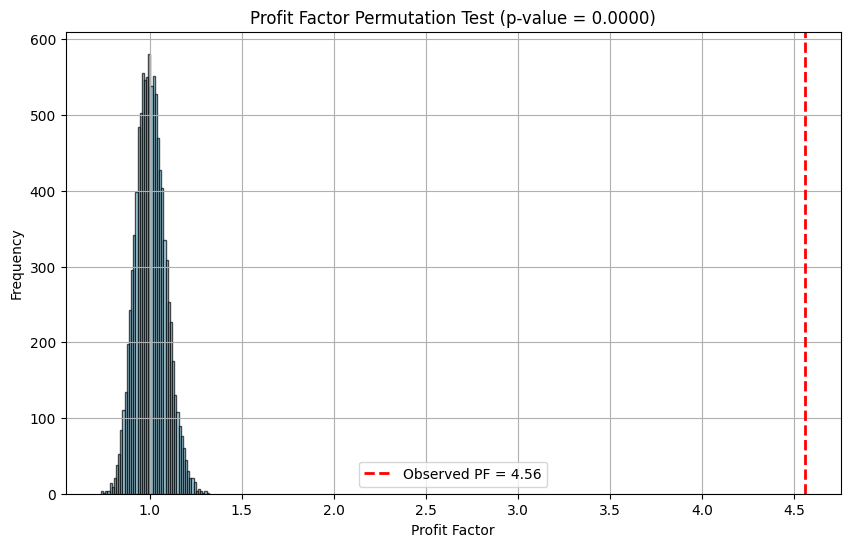


=== Profit Factor Permutation Test ===
Observed Profit Factor: 4.5600
Mean Permutation Profit Factor: 1.0033
P-value: 0.0000
Result: The observed profit factor is statistically significant (p < 0.05)


In [15]:
# Run the walk-forward analysis
oos_results, profit_factor_pvalue = run_walkforward_analysis(
    tickers=tickers,
    start_date=start_date,
    end_date=end_date,
    use_trailing_stop=True,
    exit_bars=30
)